Visualization

In [ ]:
!pip install open3d matplotlib numpy Vispy PyQt5

In [26]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

file1 = '000000.bin'
file2 = '000000.label'

cloud1 = np.fromfile(file1, dtype=np.float32)
print(cloud1.shape)

cloud1 = cloud1.reshape((-1, 4))
xyz = cloud1[:, :3]
x = cloud1[:, 0]
y = cloud1[:, 1]
z = cloud1[:, 2]
ref = cloud1[:, 3:]
print(cloud1.shape)

label = np.fromfile(file2, dtype=np.int32)
print(label.shape)
distinct = np.unique(label)
print(distinct)


(524288,)
(131072, 4)
(131072,)
[ 3  4 17 18 19 23 27 31 33]


panorama

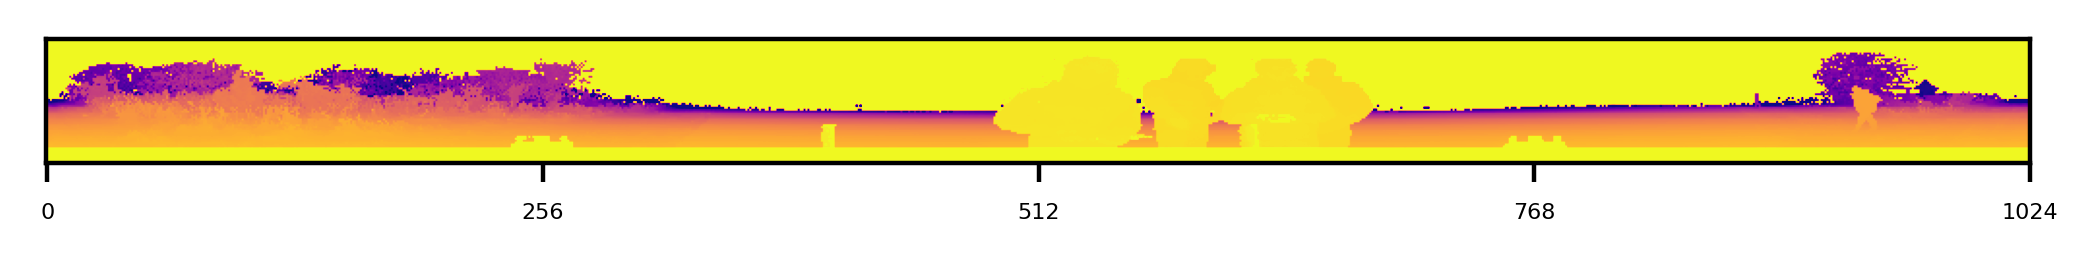

In [21]:
H = 64
W = 1024

fov_up = np.pi / 8 # 45 / 2 deg
fov_down = -np.pi / 8
fov = np.abs(fov_up) + np.abs(fov_down)

# convert to spherical coords
rad = np.linalg.norm(xyz, 2, axis=1) # radius of points from origin
rad[rad == 0] = 1e-4 # adjust origin to make warping work

yaw = -np.arctan2(y, x) # phi
pitch = np.arcsin(z / rad) # theta

# (rad, yaw, pitch)
# now map to 2d image of yaw x pitch
# yaw goes [-pi, pi] and pitch goes [fov_down, fov_up]
proj_x_unit = 0.5 * (yaw / np.pi + 1.0) # scaled to [0,1]
proj_y_unit = 1.0 - (pitch + np.abs(fov_down)) / fov # scaled to [0,1]
proj_x = proj_x_unit * W # [0, W]
proj_y = proj_y_unit * H # [0, H]

# convert to indices
proj_x = np.floor(proj_x)
proj_x = np.minimum(W - 1, proj_x)
proj_x = np.maximum(0, proj_x).astype(np.int32)

proj_y = np.floor(proj_y)
proj_y = np.minimum(H - 1, proj_y)
proj_y = np.maximum(0, proj_y).astype(np.int32)

u = proj_x.copy()
v = proj_y.copy()
u, v


panorama = np.full((H, W), -1, dtype=np.float32)
panorama[v, u] = rad

# Note, origin is top left corner

plt.figure(dpi=400)
plt.imshow(panorama, cmap='plasma_r', vmin=0, vmax=30)
ax = plt.gca()
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks([0,256,512,768,1024])
ax.set_xticklabels([0,256,512,768,1024], fontsize=4)
plt.show()

In [43]:
label_color = {
    0: (255, 0, 0),      # Red
    1: (0, 255, 0),      # Green
    2: (0, 0, 255),      # Blue
    3: (255, 255, 0),    # Yellow
    4: (255, 0, 255),    # Magenta
    5: (0, 255, 255),    # Cyan
    6: (128, 0, 0),      # Maroon
    7: (0, 128, 0),      # Olive
    8: (0, 0, 128),      # Navy
    9: (128, 128, 0),    # Yellow-green
    10: (128, 0, 128),   # Purple
    11: (0, 128, 128),   # Teal
    12: (192, 192, 192), # Silver
    13: (128, 128, 128), # Gray
    14: (255, 99, 71),   # Tomato
    15: (255, 140, 0),   # Darkorange
    16: (255, 165, 0),   # Orange
    17: (255, 215, 0),   # Gold
    18: (154, 205, 50),  # YellowGreen
    19: (46, 139, 87),   # SeaGreen
    20: (0, 100, 0),     # DarkGreen
    21: (0, 255, 127),   # SpringGreen
    22: (0, 255, 255),   # Aqua/Cyan
    23: (32, 178, 170),  # LightSeaGreen
    24: (0, 255, 255),   # Cyan/Aqua
    25: (72, 61, 139),   # DarkSlateBlue
    26: (139, 0, 139),   # DarkMagenta
    27: (218, 112, 214), # Orchid
    28: (255, 0, 255),   # Fuchsia/Magenta
    29: (255, 105, 180), # HotPink
    30: (199, 21, 133),  # MediumVioletRed
    31: (255, 255, 0),   # Yellow
    32: (210, 180, 140), # Tan
    33: (240, 230, 140), # Khaki
    34: (245, 222, 179)  # Wheat
}

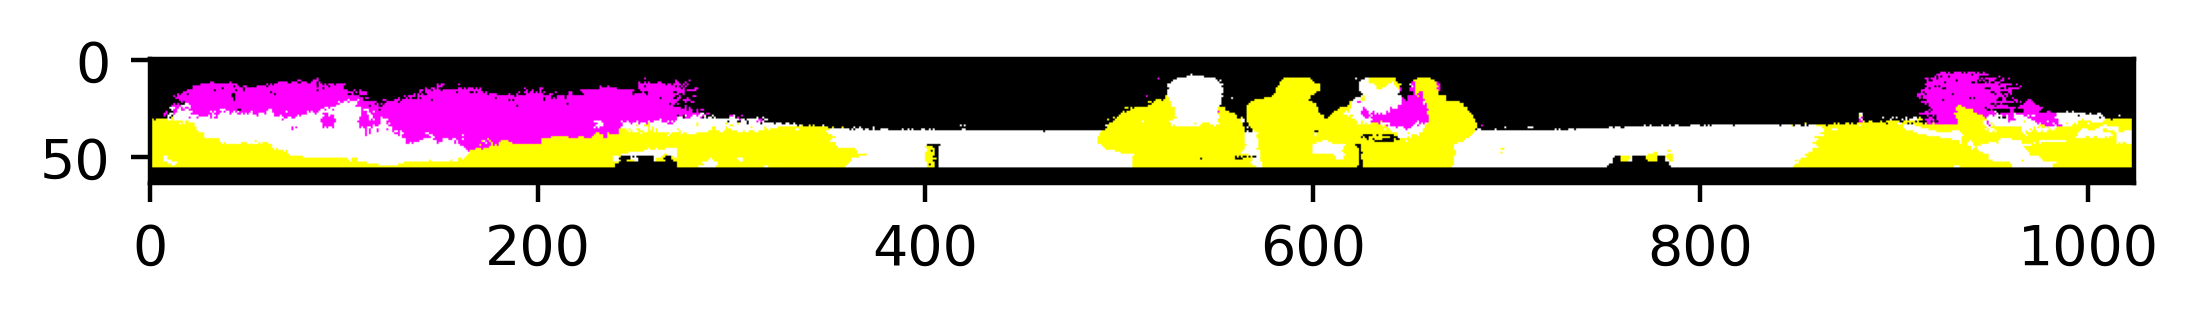

In [47]:
label = np.fromfile(file2, dtype=np.int32)
label = label.reshape((-1))
sem_labels = label & 0xFFFF # extract sem label (other part is instance id)

# label_color_def = {
#     0: (255, 0, 0),   # Red
#     3: (0, 255, 0),   # Green
#     4: (0, 0, 255),   # Blue
#     5: (255, 255, 0), # Yellow
#     19: (255, 0, 255),# Magenta
#     31: (0, 255, 255),# Cyan
#     33: (128, 128, 128) # Gray
# }

color_map = np.zeros((35, 3), dtype=np.uint8)
for l, color in label_color.items():
    color_map[l] = color

sem_panorama = np.full((H, W, 3), 0, dtype=np.float32)
sem_panorama[v, u] = color_map[label]

plt.figure(dpi=400)
plt.imshow(sem_panorama)

point cloud

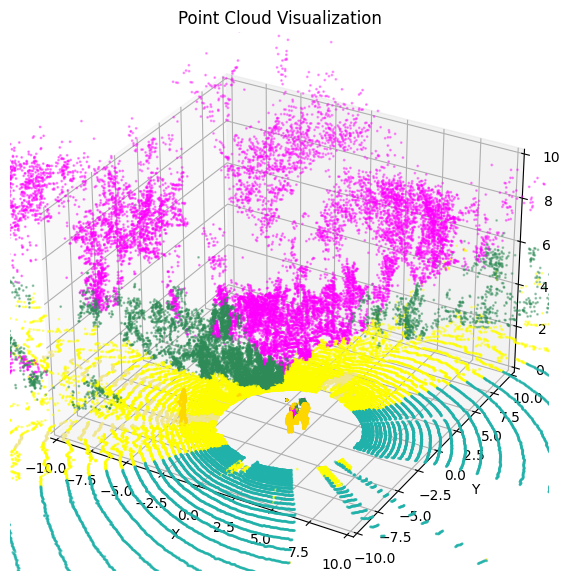

In [49]:
# prob = np.random.random((20, 2048 * 64))  # Mock softmax scores
# prob = prob / np.sum(prob, axis=0, keepdims=True)

# xyz = cloud1[:, :3]
# class_predictions = np.argmax(prob.T, axis=1)

# num_classes = 20
# colormap = plt.get_cmap('tab20', num_classes)
# colors = colormap(class_predictions / num_classes)[:,:3]

label = np.fromfile(file2, dtype=np.int32)
label = label.reshape((-1))
sem_labels = label & 0xFFFF # extract sem label (other part is instance id)

# label_color_def = {
#     0: (255, 0, 0),   # Red
#     3: (0, 255, 0),   # Green
#     4: (0, 0, 255),   # Blue
#     5: (255, 255, 0), # Yellow
#     19: (255, 0, 255),# Magenta
#     31: (0, 255, 255),# Cyan
#     33: (128, 128, 128) # Gray
# }


color_map = np.zeros((35, 3), dtype=np.uint8)

for key, color in label_color.items():
    color_map[key] = color

mapped_colors = color_map[label]

# Plotting with plt
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=mapped_colors / 255.0, marker='o', s=1)

plt.title('Point Cloud Visualization')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([0, 10])

plt.show()